**Required Packages needed for the Models**

In [36]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.models import Sequential 
from tensorflow.keras.layers import InputLayer, TimeDistributed, LSTM, Reshape, BatchNormalization, Dropout, Flatten, Dense, Activation, MaxPooling2D, Conv2D
from tensorflow.keras.callbacks import LearningRateScheduler, EarlyStopping
import keras.backend as K
from tensorflow.keras.metrics import BinaryAccuracy, Precision, Recall, AUC
from tensorflow.keras.losses import CategoricalCrossentropy
from skimage.io import imread, imshow
from skimage.transform import resize
import os
import os.path
import itertools
from sklearn.metrics import confusion_matrix
import splitfolders

**Image Preproccessing**

Splitting Training Data into Train and Validation Data.
## If data is already split into val, test, train. skip this step.
## If not delete orginal train folder so there is no duplicate

In [38]:
splitfolders.ratio("/Users/williamjones/Downloads/AlzheimerDataset/train",
                   output="/Users/williamjones/Downloads/AlzheimerDataset/",
                   seed=1985, 
                   ratio=(0.8, 0.2) )

Scaling for data generator

In [39]:
images = ImageDataGenerator(rescale= 1./255
                                 )

Sizing images for each set

In [40]:
train_data = images.flow_from_directory(directory="/Users/williamjones/Downloads/AlzheimerDataset/train", 
                                             target_size=(224, 224), 
                                             batch_size = 25, 
                                             class_mode = 'categorical'
                                             )

vaild_data = images.flow_from_directory(directory="/Users/williamjones/Downloads/AlzheimerDataset/val",
                                             target_size=(224, 224), 
                                             batch_size = 25, 
                                             class_mode = 'categorical'
                                             )
test_data = images.flow_from_directory(directory="/Users/williamjones/Downloads/AlzheimerDataset/test", 
                                           target_size = (224, 224), 
                                           batch_size = 25, 
                                           class_mode= 'categorical', 
                                           )

Found 4095 images belonging to 4 classes.
Found 1026 images belonging to 4 classes.
Found 1279 images belonging to 4 classes.


| | Test | Validation | Train |
| :- | :-: | :-: | :-: |
| Mild | 179 | 144 | 573
| Very Mild | 448 | 359 | 1433
| Moderate | 12 | 11 | 41
| NonDemented | 640 | 512 | 2048



**LSTM CNN**

In [41]:

def build_model_lstmcnn():
    #cnn
    cnn = Sequential()
    
    cnn.add(Conv2D(16, (3, 3), padding='same', input_shape= (224, 224, 3), activation='relu'))
    cnn.add(Conv2D(16, (3, 3), padding='same', activation='relu'))
    cnn.add(MaxPooling2D(pool_size=(2, 2), strides=2, padding='same'))
    cnn.add(BatchNormalization())
    
    cnn.add(Conv2D(32, (3, 3,), padding='same', activation='relu'))
    #cnn.add(Dropout()())
    cnn.add(Conv2D(32, (3, 3,), padding='same', activation='relu'))
    cnn.add(MaxPooling2D(pool_size=(2, 2), strides=2, padding='same'))
    cnn.add(BatchNormalization())
    
    cnn.add(Conv2D(64, (3, 3,), padding='same', activation='relu'))
    #cnn.add(Dropout()())
    cnn.add(Conv2D(64, (3, 3,), padding='same', activation='relu'))
    cnn.add(MaxPooling2D(pool_size=(2, 2), strides=2, padding='same'))
    #cnn.add(Dropout(0.2))
    cnn.add(BatchNormalization())
    
    cnn.add(Conv2D(128, (3, 3,), padding='same', activation='relu'))
    #cnn.add(Dropout(0.2))
    cnn.add(Conv2D(128, (3, 3,), padding='same', activation='relu'))
    cnn.add(MaxPooling2D(pool_size=(2, 2), strides=2, padding='same'))
    cnn.add(BatchNormalization())
    
    cnn.add(Conv2D(256, (3, 3,), padding='same', activation='relu'))
    #cnn.add(Dropout(0.2))
    cnn.add(Conv2D(256, (3, 3,), padding='same', activation='relu'))
    cnn.add(MaxPooling2D(pool_size=(2, 2), strides=2, padding='same'))
    cnn.add(BatchNormalization())
    
    #LSTM part
    cnn.add(Reshape(target_shape=(112, 112)))
    cnn.add(LSTM(56, input_shape = (112, 112)))
    cnn.add(BatchNormalization())
    
    cnn.add(Dense(32, activation='relu'))
    cnn.add(Dropout(0.3))
    cnn.add(Dense(4, activation='relu'))
    return cnn      

cnnlstm_model = build_model_lstmcnn()
cnnlstm_model.build(input_shape=( 224, 224, 3))
cnnlstm_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_20 (Conv2D)          (None, 224, 224, 16)      448       
                                                                 
 conv2d_21 (Conv2D)          (None, 224, 224, 16)      2320      
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 112, 112, 16)     0         
 g2D)                                                            
                                                                 
 batch_normalization_12 (Bat  (None, 112, 112, 16)     64        
 chNormalization)                                                
                                                                 
 conv2d_22 (Conv2D)          (None, 112, 112, 32)      4640      
                                                                 
 conv2d_23 (Conv2D)          (None, 112, 112, 32)     

Compiling the Model and setting function for f1 score

In [42]:
def f1_score(y_true, y_pred): #taken from old keras source code
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val
cnnlstm_model.compile(optimizer='adam',
              loss=CategoricalCrossentropy(), 
              metrics=[BinaryAccuracy(name="accuarcy"), 
                       Precision(name="precision"),
                       AUC(name="auc"), 
                      Recall(name="recall"), 
                      f1_score])

Fitting the model to training data

In [43]:
def exponential_decay(l, s):
    def ed(epoch):
        return l * 0.001 **(epoch / s)
    return ed

ed = exponential_decay(0.01, 5)

cnnlstm_data = cnnlstm_model.fit(train_data, 
         validation_data=vaild_data, 
         epochs=20,
         callbacks= LearningRateScheduler(ed)
         )

Epoch 1/20
164/164 [==============================] - 106s 638ms/step - loss: nan - accuarcy: 0.7489 - precision: 0.2000 - auc: 0.4999 - recall: 0.0015 - f1_score: nan - val_loss: nan - val_accuarcy: 0.7500 - val_precision: 0.0000e+00 - val_auc: 0.5000 - val_recall: 0.0000e+00 - val_f1_score: nan - lr: 0.0100
Epoch 2/20
164/164 [==============================] - 104s 637ms/step - loss: nan - accuarcy: 0.7500 - precision: 0.0000e+00 - auc: 0.5000 - recall: 0.0000e+00 - f1_score: nan - val_loss: nan - val_accuarcy: 0.7500 - val_precision: 0.0000e+00 - val_auc: 0.5000 - val_recall: 0.0000e+00 - val_f1_score: nan - lr: 0.0025
Epoch 3/20
164/164 [==============================] - 105s 642ms/step - loss: nan - accuarcy: 0.7500 - precision: 0.0000e+00 - auc: 0.5000 - recall: 0.0000e+00 - f1_score: nan - val_loss: nan - val_accuarcy: 0.7500 - val_precision: 0.0000e+00 - val_auc: 0.5000 - val_recall: 0.0000e+00 - val_f1_score: nan - lr: 6.3096e-04
Epoch 4/20
164/164 [===========================

**CNN**

In [9]:


def build_model_cnn():
    model = Sequential()
    
    model.add(Conv2D(16, (3, 3), padding='same', input_shape= (224, 224, 3), activation='relu'))
    model.add(Conv2D(16, (3, 3), padding='same', activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2), strides=2, padding='same'))
    
    model.add(Conv2D(32, (3, 3,), padding='same', activation='relu'))
    model.add(Conv2D(32, (3, 3), padding='same', activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2), strides=2, padding='same'))

    model.add(Conv2D(64, (3, 3,), padding='same', activation='relu'))
    model.add(Conv2D(64, (3, 3,), padding='same', activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2), strides=2, padding='same'))

    model.add(Conv2D(128, (3, 3,), padding='same', activation='relu'))
    model.add(Conv2D(128, (3, 3,), padding='same', activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2), strides=2, padding='same'))

    model.add(Conv2D(256, (3, 3,), padding='same', activation='relu'))
    model.add(Conv2D(256, (3, 3,), padding='same', activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2), strides=2, padding='same'))

    model.add(Conv2D(512, (3, 3,), padding='same', activation='relu'))
    model.add(Conv2D(512, (3, 3,), padding='same', activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2), strides=2, padding='same'))
    
    model.add(Flatten())
    
    model.add(Dense(512, activation='relu'))
    model.add(BatchNormalization())
    #model.add(Dropout(0.7))
    
    model.add(Dense(128, activation='relu'))
    model.add(BatchNormalization())
    #model.add(Dropout(0.5))
    
    model.add(Dense(64, activation='relu'))
    model.add(BatchNormalization())
   # model.add(Dropout(0.5))
    
    model.add(Dense(32, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.2))
    
    model.add(Dense(4)
    
    return model

model = build_model_cnn()

model.summary()
    

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_10 (Conv2D)          (None, 224, 224, 16)      448       
                                                                 
 conv2d_11 (Conv2D)          (None, 224, 224, 16)      2320      
                                                                 
 batch_normalization_6 (Batc  (None, 224, 224, 16)     64        
 hNormalization)                                                 
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 112, 112, 16)     0         
 2D)                                                             
                                                                 
 conv2d_12 (Conv2D)          (None, 112, 112, 32)      4640      
                                                                 
 conv2d_13 (Conv2D)          (None, 112, 112, 32)     

In [10]:
def f1_score(y_true, y_pred): #taken from old keras source code
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val
model.compile(optimizer='adam',
              loss=CategoricalCrossentropy(), 
              metrics=[BinaryAccuracy(name="accuarcy"),
                       Precision(name="precision"),
                       AUC(name="auc"),
                       Recall(name="recall"), 
                       f1_score ])

In [11]:
def exponential_decay(l, s):
    def ed(epoch):
        return l * 0.001 **(epoch / s)
    return ed

ed = exponential_decay(0.01, 5)




cnn_data = model.fit(train_data, 
         validation_data=vaild_data, 
         epochs=20,
         callbacks= LearningRateScheduler(ed)
         )

Epoch 1/20
164/164 [==============================] - 139s 841ms/step - loss: 1.0801 - accuarcy: 0.7618 - precision: 0.5449 - auc: 0.7786 - recall: 0.2860 - f1_score: 0.3723 - val_loss: 29.2473 - val_accuarcy: 0.7513 - val_precision: 0.5027 - val_auc: 0.6697 - val_recall: 0.4965 - val_f1_score: 0.4996 - lr: 0.0100
Epoch 2/20
164/164 [==============================] - 137s 838ms/step - loss: 0.9730 - accuarcy: 0.7837 - precision: 0.7146 - auc: 0.8086 - recall: 0.2244 - f1_score: 0.3408 - val_loss: 1.0040 - val_accuarcy: 0.7847 - val_precision: 0.6537 - val_auc: 0.8153 - val_recall: 0.2950 - val_f1_score: 0.4020 - lr: 0.0025
Epoch 3/20
164/164 [==============================] - 138s 841ms/step - loss: 0.9637 - accuarcy: 0.7846 - precision: 0.7001 - auc: 0.8148 - recall: 0.2418 - f1_score: 0.3583 - val_loss: 1.0742 - val_accuarcy: 0.7513 - val_precision: 1.0000 - val_auc: 0.7589 - val_recall: 0.0054 - val_f1_score: 0.0102 - lr: 6.3096e-04
Epoch 4/20
164/164 [==============================

**LSTM**

**Comparison** 
## Loss 

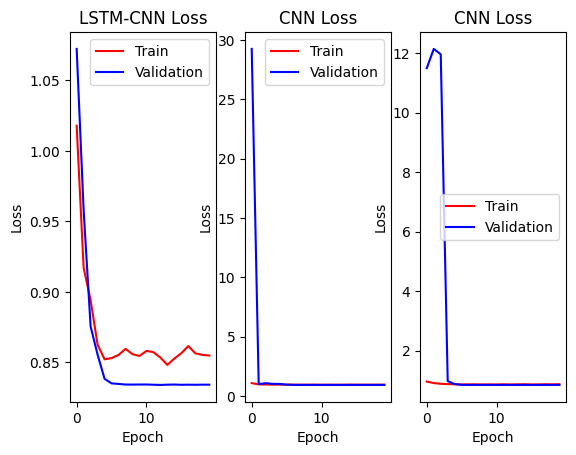

In [15]:
plt.subplot(1, 2, 1)
plt.plot(cnnlstm_data.history['loss'], 'r', cnnlstm_data.history['val_loss'], 'b')
plt.title('LSTM-CNN Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'])


plt.subplot(1, 2, 2)
plt.plot(cnn_data.history['loss'],'r',  cnn_data.history['val_loss'], 'b')
plt.title('CNN Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'])


## Precision

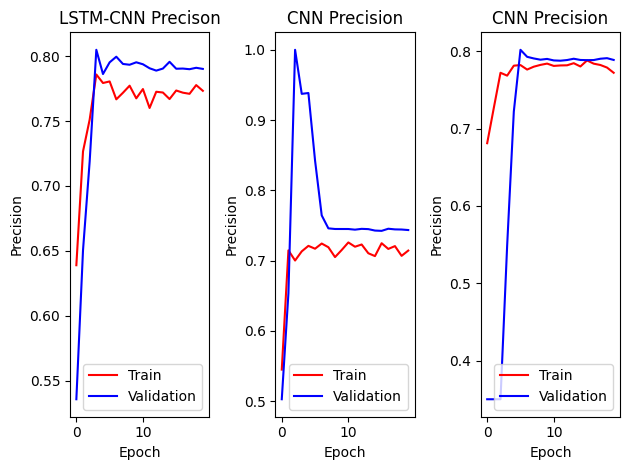

In [121]:
plt.subplot(1, 2, 1)
plt.plot(cnnlstm_data.history['precision'], 'r', cnnlstm_data.history['val_precision'], 'b')
plt.title('LSTM-CNN Precision')
plt.xlabel('Epoch')
plt.ylabel('Precision')
plt.legend(['Train', 'Validation'])


plt.subplot(1, 2, 2)
plt.plot(cnn_data.history['precision'],'r',  cnn_data.history['val_precision'], 'b')
plt.title('CNN Precision')
plt.xlabel('Epoch')
plt.ylabel('Precision')
plt.legend(['Train', 'Validation'])



## Area Under the ROC Curve

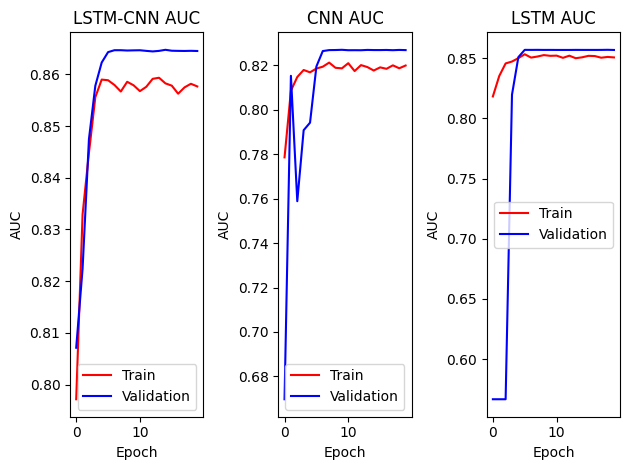

In [120]:
plt.subplot(1, 2, 1)
plt.plot(cnnlstm_data.history['auc'], 'r', cnnlstm_data.history['val_auc'], 'b')
plt.title('LSTM-CNN AUC')
plt.xlabel('Epoch')
plt.ylabel('AUC')
plt.legend(['Train', 'Validation'])


plt.subplot(1, 2, 2)
plt.plot(cnn_data.history['auc'],'r',  cnn_data.history['val_auc'], 'b')
plt.title('CNN AUC')
plt.xlabel('Epoch')
plt.ylabel('AUC')
plt.legend(['Train', 'Validation'])

plt.tight_layout()


## F1 Score

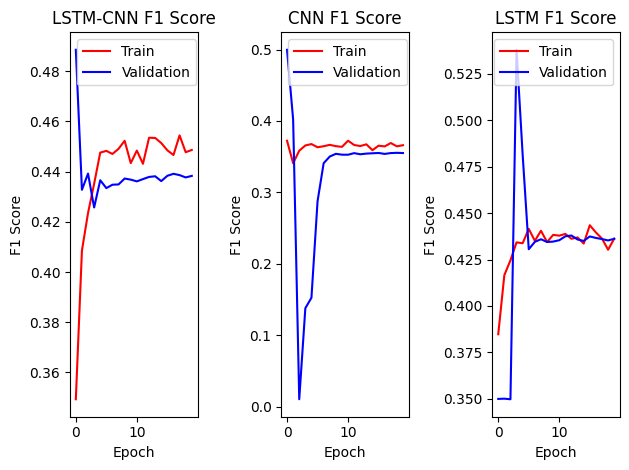

In [119]:
plt.subplot(1, 2, 1)
plt.plot(cnnlstm_data.history['f1_score'], 'r', cnnlstm_data.history['val_f1_score'], 'b')
plt.title('LSTM-CNN F1 Score')
plt.xlabel('Epoch')
plt.ylabel('F1 Score')
plt.legend(['Train', 'Validation'])


plt.subplot(1, 2, 2)
plt.plot(cnn_data.history['f1_score'],'r',  cnn_data.history['val_f1_score'], 'b')
plt.title('CNN F1 Score')
plt.xlabel('Epoch')
plt.ylabel('F1 Score')
plt.legend(['Train', 'Validation'])

plt.tight_layout()




In [19]:
#cnn
loss, accuracy,prec,  auc, recall, f1_score = model.evaluate(test_data)
print("Test Data Metrics")
print("Loss: ", loss, " Accuracy: " ,accuracy," AUC: " ,auc, " F1 Score: ", f1_score)


52/52 [==============================] - 9s 171ms/step - loss: 0.9324 - accuarcy: 0.7907 - precision: 0.6656 - auc: 0.8273 - recall: 0.3268 - f1_score: 0.4344
Test Data Metrics
Loss:  0.9323554635047913  Accuracy:  0.7906567454338074  AUC:  0.827278733253479  F1 Score:  0.4343659281730652


In [21]:
#lstm cnn
loss1, accuracy1,prec1,  auc1, recall1, f1_score1 = cnnlstm_model.evaluate(test_data)
print("Test Data Metrics")
print("Loss: ", loss, " Accuracy: " ,accuracy," AUC: " ,auc, " F1 Score: ", f1_score)



52/52 [==============================] - 8s 147ms/step - loss: 0.9339 - accuarcy: 0.7907 - precision: 0.8006 - auc: 0.8239 - recall: 0.2166 - f1_score: 0.3344
Test Data Metrics
Loss:  0.9323554635047913  Accuracy:  0.7906567454338074  AUC:  0.827278733253479  F1 Score:  0.3343929946422577


| Metric| CNN | LSTM-CNN |
| :- | -: | :-: |
| Loss | 0.9324 | 0.9339
| Precision | 0.6656 | 0.8006
| Accuracy | 0.7907 | 0.7907
| AUC | 0.8273 | 0.8239
| F1 Score | 0.4344 | 0.3344


    